# COIN-TOLIMAN Simulations doccument
---

In [1]:
import sys
import os
dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pysynphot as S

---
## Stellar modelling

Here we use the package Pysyphot (Python synthetic photometry) to generate our stellar spectra and determine photon counts etc

To simulate these stars we need to 4 values:
- Apparent Magnitude (mag)
- Effective temeperate (Teff)
- Metalicity (Z)
- Surface Gravity (log g)

With these 4 paramters we generate stellar models using the HST Phoenix library (more info found here:  https://www.hs.uni-hamburg.de/index.php?option=com_content&view=article&id=14&Itemid=294&lang=en)

---

We take the stellar values from Simbad
- Alpha Cen A: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=%403396054&Name=*%20alf%20Cen%20A&submit=submit
- Alpha Cen B :http://simbad.u-strasbg.fr/simbad/sim-id?Ident=%403396297&Name=*%20alf%20Cen%20B&submit=submit

In [3]:
# Stellar Parameters
acenA_dict = {
        "mag":0.01, # Vega mag
        "Teff":5790, 
        "Z": 0.2, 
        "log g": 4.30,
        "Model": "phoenix"
                }

acenB_dict = {
        "mag":1.33, # Vega mag
        "Teff":5260, 
        "Z": 0.23, 
        "log g": 4.37,
        "Model": "phoenix"
                }

In [32]:
# Obersrvational Paramters
aperture = 10 # cm
central_obscuration = 0 # cm
nwavels = 101
wl_range = [5450, 6450] # Angstroms
wl_range_nm = [545, 645] # nm
acenA_mag = 0.01
acenB_mag = 1.33

# Set aperture size of PSP
full_app = np.pi * (aperture/2)**2 
obsc_app = np.pi * (central_obscuration/2)**2
collecting_area = full_app - obsc_app
S.refs.setref(area=collecting_area) # Takes units of cm^2

In [5]:
# Generate stellar models
acenA = S.Icat(acenA_dict["Model"], acenA_dict["Teff"], acenA_dict["Z"], acenA_dict["log g"])
acenB = S.Icat(acenB_dict["Model"], acenB_dict["Teff"], acenB_dict["Z"], acenB_dict["log g"])

In [6]:
# Set obeservation parameters
wavels = np.linspace(wl_range[0], wl_range[1] ,nwavels)
throughput = np.ones(nwavels)

Since we do not have information about the filter we will use for now we will assume unity throughput

In [7]:
# Generate observation objects 
bandpass = S.ArrayBandpass(wavels, throughput)
specA_filt = acenA.renorm(acenA_dict["mag"], 'vegamag', bandpass)
specB_filt = acenB.renorm(acenB_dict["mag"], 'vegamag', bandpass)
acenA_obs = S.Observation(specA_filt, bandpass, binset=wavels)
acenB_obs = S.Observation(specB_filt, bandpass, binset=wavels)

In [8]:
# Find index values
start = np.where(acenA_obs.wave == wl_range[0])[0][0]
end = np.where(acenA_obs.wave == wl_range[1])[0][0]

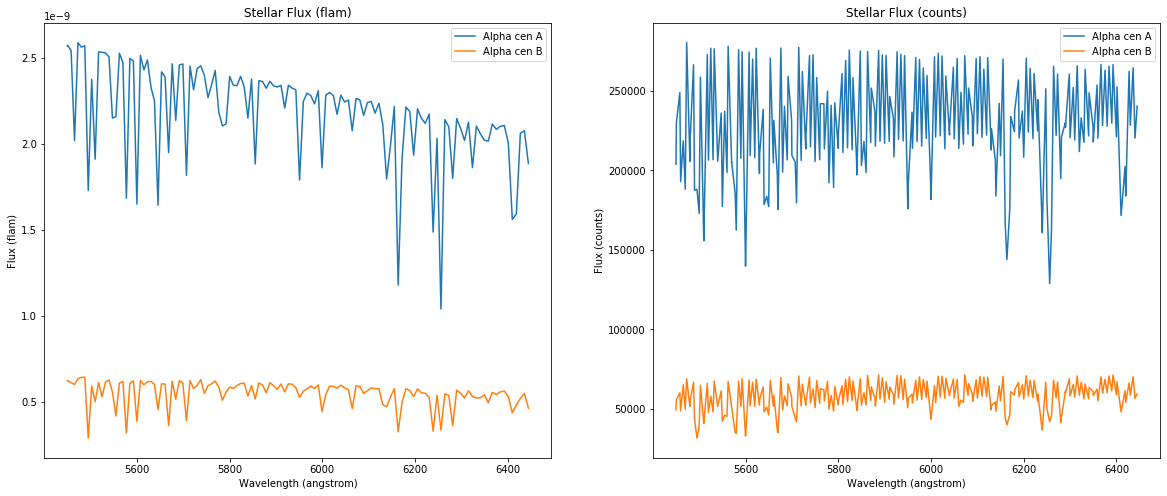

In [9]:
plt.figure(figsize=(20,8))

acenA_obs.convert('flam')
acenB_obs.convert('flam')

plt.subplot(1, 2, 1)
plt.plot(acenA_obs.wave[start:end], acenA_obs.flux[start:end], label="Alpha cen A")
plt.plot(acenB_obs.wave[start:end], acenB_obs.flux[start:end], label="Alpha cen B")
plt.title("Stellar Flux ({})".format(acenA_obs.fluxunits))
plt.ylabel('Flux ({})'.format(acenA_obs.fluxunits))
plt.xlabel('Wavelength ({})'.format(acenA_obs.waveunits))
plt.legend()

acenA_obs.convert('counts')
acenB_obs.convert('counts')

plt.subplot(1, 2, 2)
plt.plot(acenA_obs.wave[start:end], acenA_obs.flux[start:end], label="Alpha cen A")
plt.plot(acenB_obs.wave[start:end], acenB_obs.flux[start:end], label="Alpha cen B")
plt.title("Stellar Flux ({})".format(acenA_obs.fluxunits))
plt.ylabel('Flux ({})'.format(acenA_obs.fluxunits))
plt.xlabel('Wavelength ({})'.format(acenA_obs.waveunits))
plt.legend()

plt.show()

The natural resolution of these spectra is too high for our puposes so we sample at a resolution of 1nm and save the result to use later

In [49]:
resolution = 1 # nm
total_range = wl_range_nm[1] - wl_range_nm[0]

sampled_A = []
sampled_B = []
wavels = np.linspace(wl_range_nm[0], wl_range_nm[1], num=total_range+1) # +1 to account for endpoint of linspace

# Sample the spectrums
for wl in wavels:
    sampled_A.append(acenA_obs.sample(wl*10))
    sampled_B.append(acenB_obs.sample(wl*10))
        
sampled_A = np.array(sampled_A)
sampled_B = np.array(sampled_B)

np.save("AcenA_cps_{}.npy".format(resolution), sampled_A)
np.save("AcenB_cps_{}.npy".format(resolution), sampled_B)
np.save("Wavelengths.npy", wavels)

In [13]:
acenA_rate = int(acenA_obs.countrate())
acenB_rate = int(acenB_obs.countrate())
ratio = acenA_rate/acenB_rate

print("Alpha cen A photons per second: {}".format(acenA_rate))
print("Alpha cen B photons per second: {}".format(acenB_rate))
print("Flux ratio (photon counts): {}".format(ratio))

Alpha cen A photons per second: 51587416
Alpha cen B photons per second: 13084402
Flux ratio (photon counts): 3.942665167273216


These values appear to roughly agree with the flux ratio determined by the vega mags

$ m_A - m_B = -2.5 log_{10}(\frac{flux_A}{flux_B})$  ->   $\frac{flux_A}{flux_B} = 10^{\frac{0.1 - 1.33}{-2.5}} = 3.1$

---

## Signal and noise values

For our purposes we will assume that each image we produce is integrated for a full 24 hours
> 24 * 60 * 60 = 86.4k seconds

If we assume we the camera is run @ 10Hz

> 86400 * 10 = 864k frames

*Camera properies:* (GPixel GSENSE2020BSI, specs taken from the "TOLIBOY: Working Baseline optical design, 10cm aperture. Discussion Document" and this page: https://gpixel.com/products/geen-categorie/gsense2020bsi/

- Dark current: 80 electrons/pixel/second
- Read noise: 1.3 electrons/pixel
- Quantum efficiency: 95%
- Full well: 45k electrons

We will assume that we are not near pixel saturation in any frames.

This page was also used as a resource in determining the detector noise: http://kmdouglass.github.io/posts/modeling-noise-for-image-simulations/

In [14]:
# Define values
spd = 86400 # Seconds per day
fpd = spd*10 # Frames per day

# Camera values
dark_current = 80
read_noise = 1.3
QE = 0.95
full_well = 45e3
fps = 10
npix = 2048

# Gaussian noise
dark_noise = read_noise + (dark_current/fps)
noise = np.round(np.random.normal(scale=dark_noise*(fpd**0.5), size=[npix, npix]))

# Stellar values
rpd_A = spd*acenA_rate # Rate per day
rpd_B = spd*acenB_rate # Rate per day

print("Alpha cen A photons per image: {}".format(rpd_A))
print("Alpha cen B photons per image: {}".format(rpd_B))

Alpha cen A photons per image: 4457152742400
Alpha cen B photons per image: 1130492332800


This should be more than enough to measure a signal down to 10^-6 of a pixel (which should occur on order of a few hours)

---
## Current simulation state:

As of the time of the original writing of this doccument (24/03/2020) there exists a library of simulated data on the COIN servers (coin01.hopto.org)

The bulk of these simulations are Fourier Trasnform based, oriented around the goal of extracting a signal at 10^-6 of a pixel in simplest case (only photon and detector noise)

---

## Future simulations

The idea behind adding this complexity is to test the robustness of the algorithms to certain real-world effects and abberations. These complexities will be added onto the current simulation one at a time, and then added together in pairs and finally all added together

1. Translation and rotation:
 - Translation of the binary pair across the detector 
 - Rotation of the telescope 
 


2. Plate scale variation: (Low order, global shifts)
 - Defocusing of the telescope
 - Change in effective temperature of the stellar spectra
 


3. Local distortions: (High order, local shifts)
 - Higher order optical distortions across the detector

---

### Translation and rotation

Each presented 'image' is the combination of 24 hours worth of photons, however these rotation and translation effects occur over time scales of seconds to hours. As a result rather than simulating almost a million images for each day day, we simulate a single day in one image and _*test the algorithms robustness to these effects.*_


*Translation*
> Presumably we only need to translate *on order of a single pixel*, as any translation greater than this would be the same as shifting the entire pattern some integer number of pixels plus the sub pixel shift, therefore we intoduce a random sub pixel shift to each 'image'.

**Do we need to also randomly shift which pixel the stars are centerd on?**

*Rotation*
> This can be simulated by having one star 'orbit' the other with a frequency that matches the rotation of our telescope. 

*Other effects*
> **Is there any value in also introducing a linear change in binary separation over time?**


---

### Plate-scale variation

This is a global low order effect that is affected by various things. The two primary effects discussed that cause this are *defocus* and *changes in Teff*.

*Changes in Teff*
> This effect is relatively trivial to simulate with the present architechture as the stellar spectra that are used are generated using Teff as an input paramter, Therefore we can create some time-varying signal to impose on the Teff and feed this into the simulations.

*Defocus*
> **How would this effect be simulated with Fourier Transforms?**

---

### Local distortions

To be announced... One step at a time